# <center> Построение адаптивных моделей в statsmodels </center>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

В библиотеке **statsmodels** реализованы модели прогнозирования, в т. ч. модель Хольта-Уинтерса. Все рассмотренные ранее модели, в основе которых лежит метод экспоненциального сглаживания, реализованы в модуле `statsmodels.tsa.holtwinters`.

## 1. Простое экспоненциальное сглаживание

Функция `SimpleExpSmoothing` предназначена для построения простого экспоненциального сглаживания. Построим модель экспоненциального сглаживания для прогнозирования объемов пассажирских авиаперевозок в Австралии.

In [2]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [3]:
ausair = pd.read_csv('data/ausair.csv', index_col='Year', parse_dates=True)
ausair = ausair['Passengers'][20:]
ausair.index = pd.DatetimeIndex(ausair.index, freq='YS')

В качестве аргумента фукнции `SimpleExpSmoothing` выступает исходный временной ряд. Для опредения оптимального параметра сглаживания $\alpha$ воспользуемся методом `fit()` модели.

In [4]:
ses = SimpleExpSmoothing(ausair, initialization_method='estimated').fit()

Помимо параметра сглаживания $\alpha$ функция `SimpleExpSmoothing` определяет начальное значение уровня $l_0$, которое также влияет на результат прогнозирования. Значения $\alpha$ и $l_0$ можно задать вручную:

In [5]:
y0 = ausair.values[0]
ses_lvl = SimpleExpSmoothing(ausair, initialization_method='known', initial_level=y0)
ses_lvl = ses_lvl.fit(smoothing_level=0.8, optimized=False)

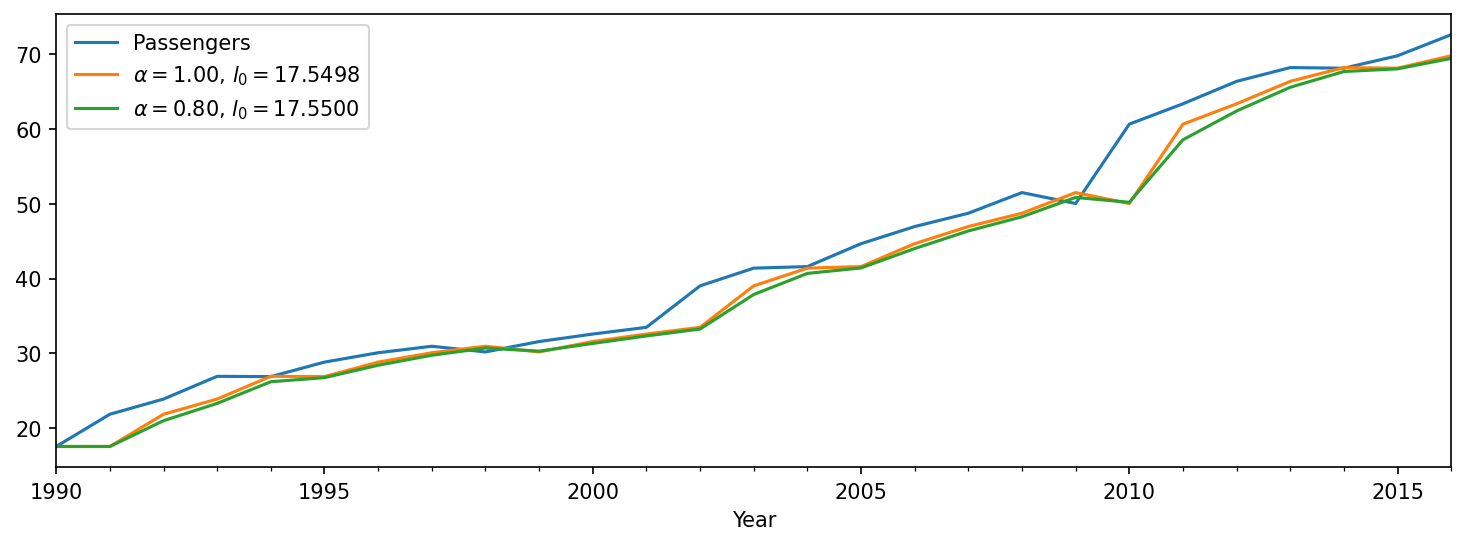

In [6]:
plt.figure(figsize=(12, 4), dpi=150)
ausair.plot(legend=True)
ses.fittedvalues.rename(r'$\alpha=%.2f$' % ses.model.params['smoothing_level'] + ', ' +
                        r'$l_0=%.4f$' % ses.model.params['initial_level']).plot(legend=True)
ses_lvl.fittedvalues.rename(r'$\alpha=%.2f$' % ses_lvl.model.params['smoothing_level'] + ', ' +
                            r'$l_0=%.4f$' % ses_lvl.model.params['initial_level']).plot(legend=True)
plt.show()

Для построения прогноза воспользуемся методом `.forecast()`, указав горизонт прогнозирования.

In [7]:
ses_forecast = ses.forecast(10)
ses_lvl_forecast = ses_lvl.forecast(10)

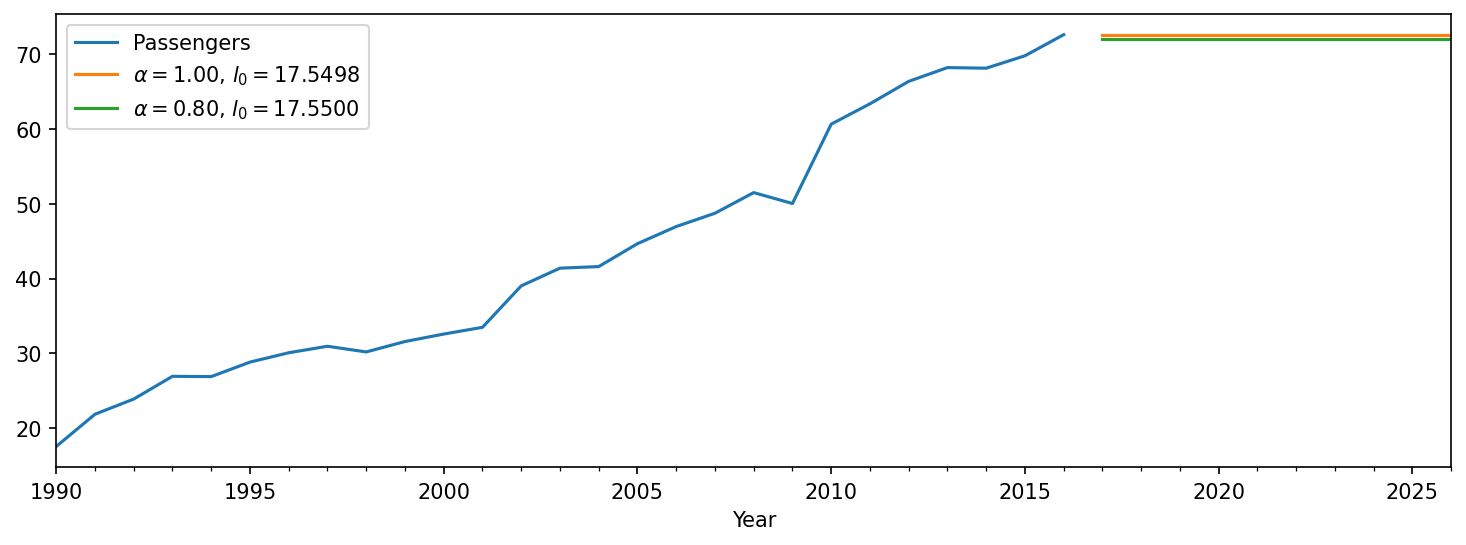

In [8]:
plt.figure(figsize=(12,4), dpi=150)
ausair.plot(legend=True)
ses_forecast.rename(r'$\alpha=%.2f$' % ses.model.params['smoothing_level'] + ', ' +
                    r'$l_0=%.4f$' % ses.model.params['initial_level']).plot(legend=True)
ses_lvl_forecast.rename(r'$\alpha=%.2f$' % ses_lvl.model.params['smoothing_level'] + ', ' +
                        r'$l_0=%.4f$' % ses_lvl.model.params['initial_level']).plot(legend=True)
plt.show()

**Важно!** Если не задан период наблюдений, то statsmodels может построить прогноз с неожиданного индекса. Чтобы явно передать, для каких дат необходимо построить прогноз, можно воспользоваться методом `.predict(start, end)`.

In [9]:
start = ausair.index[-1] + pd.DateOffset(years=1)
end = start + pd.DateOffset(years=9)
start, end

(Timestamp('2017-01-01 00:00:00'), Timestamp('2026-01-01 00:00:00'))

In [10]:
ses.predict(start=start, end=end)

2017-01-01    72.6
2018-01-01    72.6
2019-01-01    72.6
2020-01-01    72.6
2021-01-01    72.6
2022-01-01    72.6
2023-01-01    72.6
2024-01-01    72.6
2025-01-01    72.6
2026-01-01    72.6
Freq: AS-JAN, dtype: float64

## 2. Метод Хольта

Для рядов с трендом можно воспользоваться функцией `Holt`.

In [11]:
from statsmodels.tsa.holtwinters import Holt

In [12]:
holt = Holt(ausair, initialization_method='estimated').fit()

b0 = ausair.values[1] - ausair.values[0]
holt_initial = Holt(ausair, initialization_method='known', initial_level=y0, initial_trend=b0)
holt_initial = holt_initial.fit(smoothing_level=0.59, smoothing_trend=0.43, optimized=False)

In [13]:
alpha = holt.model.params['smoothing_level']
beta = holt.model.params['smoothing_trend']
l0 = holt.model.params['initial_level']
b0 = holt.model.params['initial_trend']
print('Best params: ')
print('alpha = {:.2f},'.format(alpha), 'beta = {:.2f}'.format(beta))
print('l0  = {:.2f},'.format(l0), 'b0 = {:.2f}'.format(b0))

Best params: 
alpha = 0.82, beta = 0.00
l0  = 15.85, b0 = 2.10


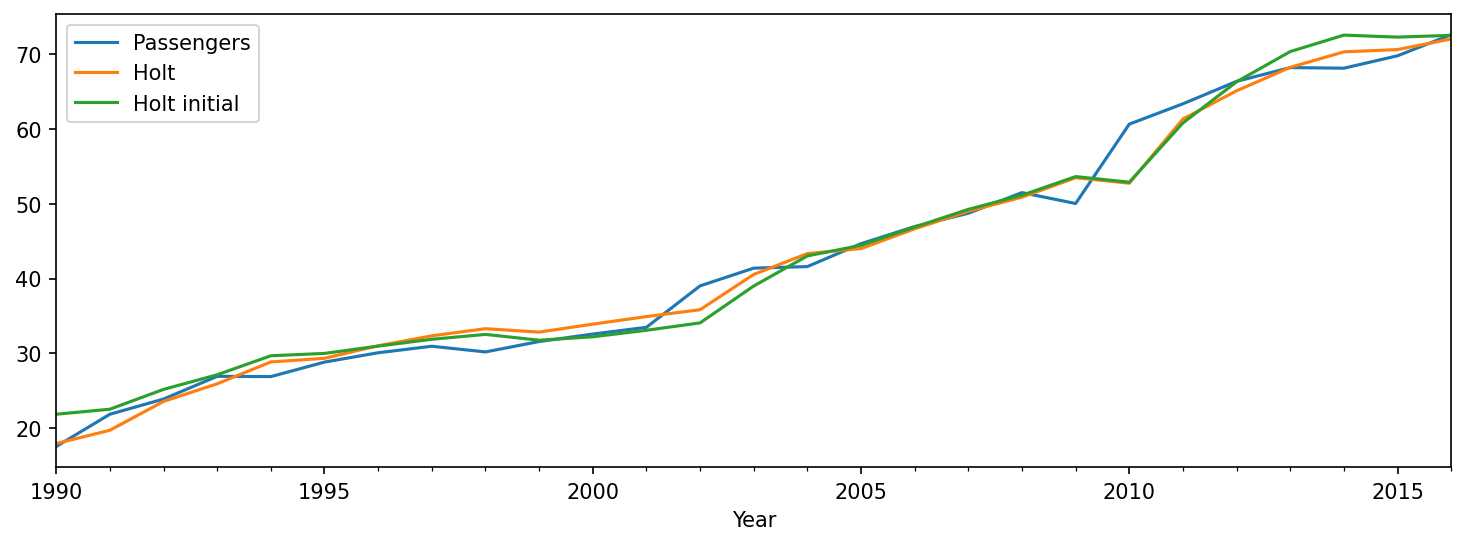

In [14]:
plt.figure(figsize=(12,4), dpi=150)
ausair.plot(legend=True)
holt.fittedvalues.rename('Holt').plot(legend=True)
holt_initial.fittedvalues.rename('Holt initial').plot(legend=True)
plt.show()

In [15]:
#version 0.12.2
#pip install -U statsmodels

In [16]:
import statsmodels
statsmodels.__version__

'0.13.2'

In [17]:
holt_damped = Holt(ausair, damped_trend=True, initialization_method='estimated').fit()

b0 = ausair.values[1] - ausair.values[0]
holt_damped_initial = Holt(ausair, damped_trend=True, initialization_method='known', 
                           initial_level=y0, initial_trend=b0)
holt_damped_initial = holt_damped_initial.fit(smoothing_level=0.39, 
                                              smoothing_trend=0.10,
                                              damping_trend=0.9,
                                              optimized=False)

In [18]:
alpha = holt_damped.model.params['smoothing_level']
beta = holt_damped.model.params['smoothing_trend']
l0 = holt_damped.model.params['initial_level']
b0 = holt_damped.model.params['initial_trend']
phi = holt_damped.model.params['damping_trend']
print('Best params: ')
print('alpha = {:.2f},'.format(alpha), 'beta = {:.2f}'.format(beta), 'phi = {:.2f}'.format(phi))
print('l0  = {:.2f},'.format(l0), 'b0 = {:.2f}'.format(b0))

Best params: 
alpha = 0.84, beta = 0.00 phi = 0.99
l0  = 15.65, b0 = 2.24


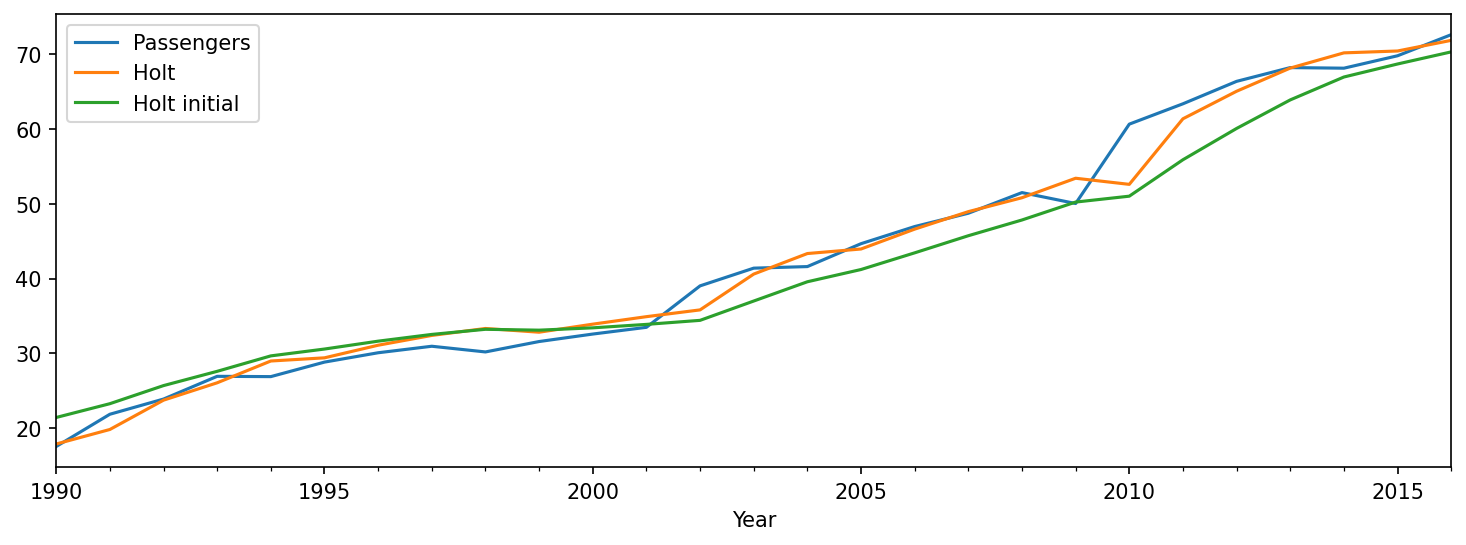

In [19]:
plt.figure(figsize=(12,4), dpi=150)
ausair.plot(legend=True)
holt_damped.fittedvalues.rename('Holt').plot(legend=True)
holt_damped_initial.fittedvalues.rename('Holt initial').plot(legend=True)
plt.show()

## 3. Метод Хольта-Уинтерса

Модель Хольта-Уинтерса для рядов с сезонностью реализована в `ExponentialSmoothing`.

In [20]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.eval_measures import mse

<a href='https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html'>Документация</a>

<div class="alert alert-info">

<h3> Задание</h3>
<p></p>
<ul>1. Постройте модель Хольта-Уинтерса для ряда <b>passengers.csv</b>.</ul>
<ul>2. Оцените качество аппроксимации с помощью среднеквадратичной ошибки.</ul>
<ul>3. Постройте прогноз на 3 года вперед и отобразите его на графике.</ul>
<p></p>
  
</div>

In [21]:
passengers = pd.read_csv("data/passengers.csv", index_col=0)
passengers = passengers["num_passengers"]
passengers.index = pd.DatetimeIndex(passengers.index, freq="MS")

### Аддитивный случай

In [22]:
holt_winters = ExponentialSmoothing(passengers, initialization_method="estimated",
                                    trend="add", seasonal="add").fit()

In [23]:
holt_winters.model.params

{'smoothing_level': 0.2525544020458561,
 'smoothing_trend': 4.754799279700359e-06,
 'smoothing_seasonal': 0.7474188908684702,
 'damping_trend': nan,
 'initial_level': 118.43668805959135,
 'initial_trend': 2.5948224850556194,
 'initial_seasons': array([ -9.09005638,  -3.44886834,   9.01885695,   3.82250723,
         -4.95519378,   9.15174385,  21.36861525,  18.83991197,
          4.60263432, -14.35375828, -28.91706568, -12.44864188]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

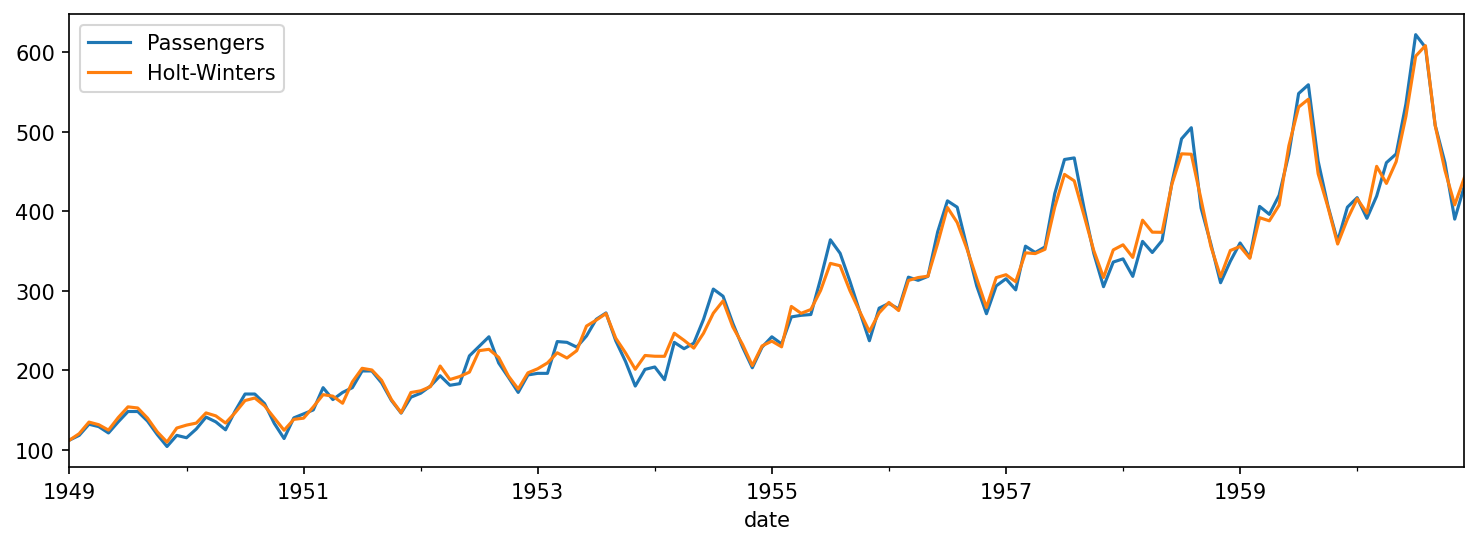

In [24]:
plt.figure(figsize=(12,4), dpi=150)
passengers.plot(label="Passengers")
holt_winters.fittedvalues.plot(label="Holt-Winters")
plt.legend(loc="upper left")
plt.show()

**Среднеквадратичная ошибка**

In [25]:
mse(passengers, holt_winters.fittedvalues)

149.7552503832539

### Мультипликативный случай

In [26]:
holt_winters_mul = ExponentialSmoothing(passengers, initialization_method="estimated",
                                        trend="add", seasonal="mul").fit()

In [27]:
holt_winters_mul.model.params

{'smoothing_level': 0.31859594384940465,
 'smoothing_trend': 1.8490587914353202e-07,
 'smoothing_seasonal': 0.6012993403302276,
 'damping_trend': nan,
 'initial_level': 102.50542786637452,
 'initial_trend': 2.4102684346753986,
 'initial_seasons': array([1.06195863, 1.11682948, 1.23328582, 1.17647451, 1.09828024,
        1.19936056, 1.30417135, 1.28820441, 1.17447872, 1.02453882,
        0.90728655, 1.03908309]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

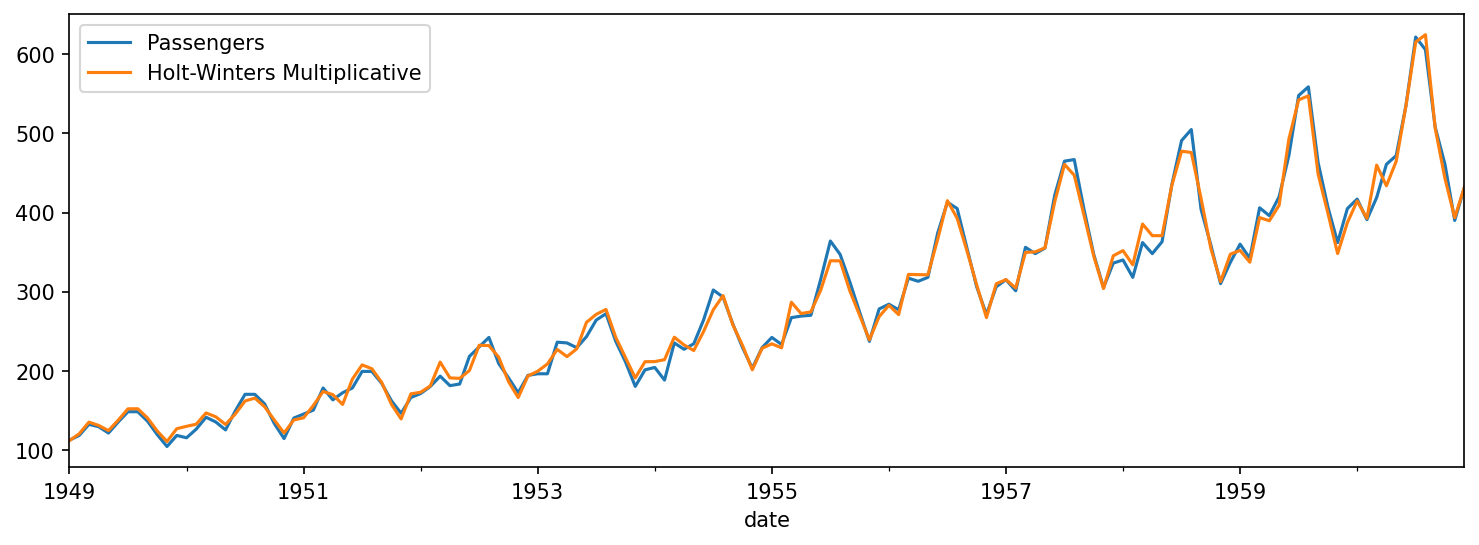

In [28]:
plt.figure(figsize=(12,4), dpi=150)
passengers.plot(label="Passengers")
holt_winters_mul.fittedvalues.plot(label="Holt-Winters Multiplicative")
plt.legend(loc="upper left")
plt.show()

**Среднеквадратичная ошибка**

In [29]:
mse(passengers, holt_winters_mul.fittedvalues)

110.78392220140296

### Прогноз

In [30]:
start = passengers.index[-1] + pd.DateOffset(months=1)
end = start + pd.DateOffset(months=35)
start, end

(Timestamp('1961-01-01 00:00:00'), Timestamp('1963-12-01 00:00:00'))

In [31]:
holt_winters_forecast = holt_winters.predict(start=start, end=end)

In [32]:
holt_winters_mul_forecast = holt_winters_mul.predict(start=start, end=end)

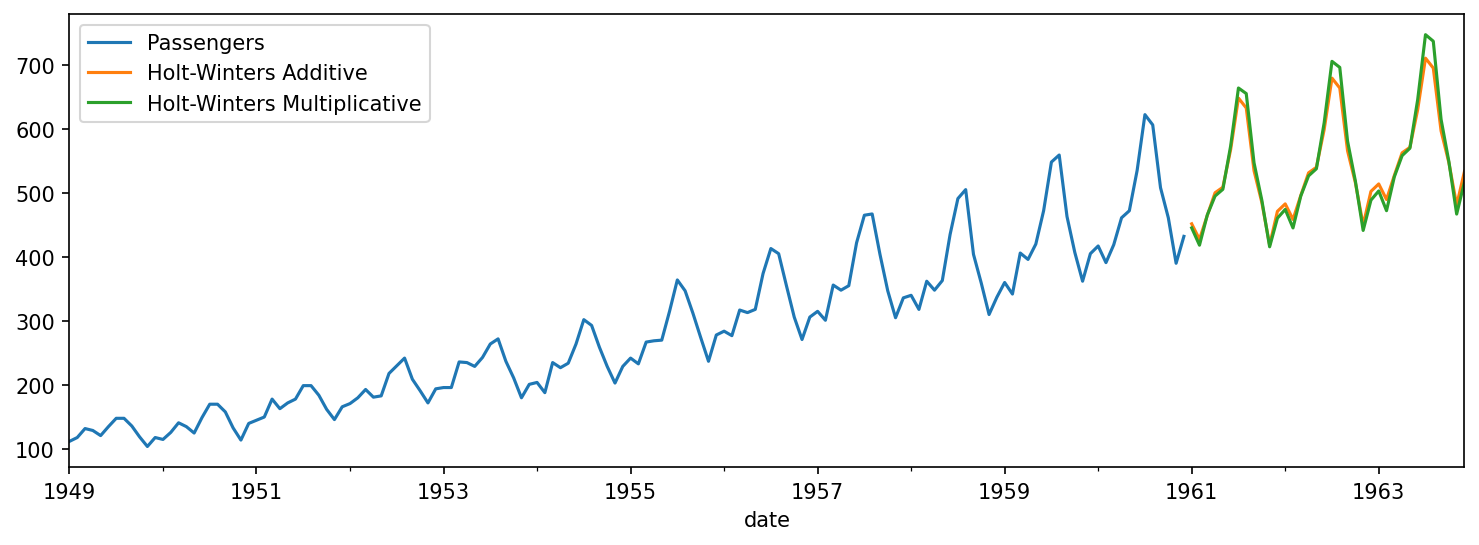

In [33]:
plt.figure(figsize=(12,4), dpi=150)
passengers.plot(label="Passengers")
holt_winters_forecast.plot(label="Holt-Winters Additive")
holt_winters_mul_forecast.plot(label="Holt-Winters Multiplicative")
plt.legend(loc="upper left")
plt.show()

<div class="alert alert-warning">

<h3> Домашнее задание</h3>    
    
<p></p> 
Выполнять в отдельном файле!
    
<ul>1. Для <b>своего</b> ряда (см. папку Данные на de.unecon) определите наилучшую адаптивную модель прогнозирования. Для этого загрузите данные и отобразите их на графике. Есть ли в ряде тренд, сезонность?</ul>
    
<ul>2. С помощью библиотеки statsmodels обучите выбранную модель и постройте прогноз. Отобразите результат на графике.</ul>
    
<ul>3. Вычислите среднеквадратичную ошибку для оценки качества аппроксимации.</ul>
<p></p>
  
</div>